In [1]:
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

sys.path.insert(1, "/home/paperspace/devinterp") # TODO fix path

from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Define the neural network
class Net(nn.Module):
    def __init__(self, hidden_layer_sizes=[1024, 1024], input_dim=28 * 28, output_dim=10,activation=F.relu, with_bias=True):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [3]:
DEVICE = 'cuda'
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20


60000


In [4]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # rlct_estimates.append(rlct_estimate)
    models += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
torch.save(models, 'models.pth')

100%|██████████| 118/118 [00:10<00:00, 11.69it/s]


Epoch 1, Train Loss: 1.4913121143640098, Test Loss: 0.5411179542541504


100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch 2, Train Loss: 0.4293575524273565, Test Loss: 0.3527143202722073


100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch 3, Train Loss: 0.33413672144130124, Test Loss: 0.3050822541117668


100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch 4, Train Loss: 0.29451288560689504, Test Loss: 0.2733851298689842


100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch 5, Train Loss: 0.26701801649089585, Test Loss: 0.2517617143690586


100%|██████████| 118/118 [00:08<00:00, 13.39it/s]


Epoch 6, Train Loss: 0.24383943250118675, Test Loss: 0.23090230114758015


100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch 7, Train Loss: 0.22414197671716496, Test Loss: 0.21421252153813838


100%|██████████| 118/118 [00:08<00:00, 13.32it/s]


Epoch 8, Train Loss: 0.20584986548302536, Test Loss: 0.20001642107963563


100%|██████████| 118/118 [00:08<00:00, 13.43it/s]


Epoch 9, Train Loss: 0.190200318093017, Test Loss: 0.18520204089581965


100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


Epoch 10, Train Loss: 0.17623614740826316, Test Loss: 0.17485086470842362


100%|██████████| 118/118 [00:08<00:00, 13.41it/s]


Epoch 11, Train Loss: 0.16374214366078377, Test Loss: 0.1621148908510804


100%|██████████| 118/118 [00:09<00:00, 12.89it/s]


Epoch 12, Train Loss: 0.15301641979712552, Test Loss: 0.15307676754891872


100%|██████████| 118/118 [00:08<00:00, 13.15it/s]


Epoch 13, Train Loss: 0.14271680417202287, Test Loss: 0.14573988746851682


100%|██████████| 118/118 [00:08<00:00, 13.27it/s]


Epoch 14, Train Loss: 0.13326194437252262, Test Loss: 0.13635661490261555


100%|██████████| 118/118 [00:08<00:00, 13.16it/s]


Epoch 15, Train Loss: 0.1256108899616589, Test Loss: 0.13118577264249326


100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch 16, Train Loss: 0.11813488375332395, Test Loss: 0.12377963587641716


100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch 17, Train Loss: 0.1118595283794201, Test Loss: 0.12083649709820747


100%|██████████| 118/118 [00:08<00:00, 13.19it/s]


Epoch 18, Train Loss: 0.10525238835963152, Test Loss: 0.11652676463127136


100%|██████████| 118/118 [00:09<00:00, 13.09it/s]


Epoch 19, Train Loss: 0.09956953320967948, Test Loss: 0.1107120887376368


100%|██████████| 118/118 [00:08<00:00, 13.24it/s]


Epoch 20, Train Loss: 0.09450993715327675, Test Loss: 0.10618572812527419


In [5]:
from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct
# todo boundary box depence
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize sgnht sampler
SGNHT_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGNHT",
        lr=1e-7,
        diffusion_factor=0.01,
        # bounding_box_size=0.0001,
        num_samples=len(train_data),
        batch_size = batch_size
    ),
    num_chains=4,
    num_draws_per_chain=400,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=batch_size,         
    criterion = 'cross_entropy' # alternatives: mse
)
SGLD_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGLD",
        lr=1e-5,
        noise_level=1.,
        # weight_decay = 0.01,
        elasticity=100.,
        temperature='adaptive',
        num_samples=len(train_data),
    ),
    num_chains=4,
    num_draws_per_chain=400,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=batch_size,         
    criterion = 'cross_entropy' # alternatives: mse
)

models = torch.load('models.pth')
rlct_estimates_sgnht = []
rlct_estimates_sgdl = []
for n in range(n_epochs):
    model = copy.deepcopy(models[n].to('cpu'))
    sgnht_sampler = Sampler(model, train_data, SGNHT_config)
    model = copy.deepcopy(models[n].to('cpu'))
    sgdl_sampler = Sampler(model, train_data, SGLD_config)
    rlct_estimate_sgnht = sgnht_sampler.sample(summary_fn=estimate_rlct)
    rlct_estimate_sgdl = sgdl_sampler.sample(summary_fn=estimate_rlct)
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgdl += [rlct_estimate_sgdl]
plt.hist(rlct_estimates_sgnht,alpha = 0.5, label='sgnht')
plt.hist(rlct_estimates_sgdl,alpha = 0.5, label='sgdl')
plt.legend()
plt.show()
# Plotting


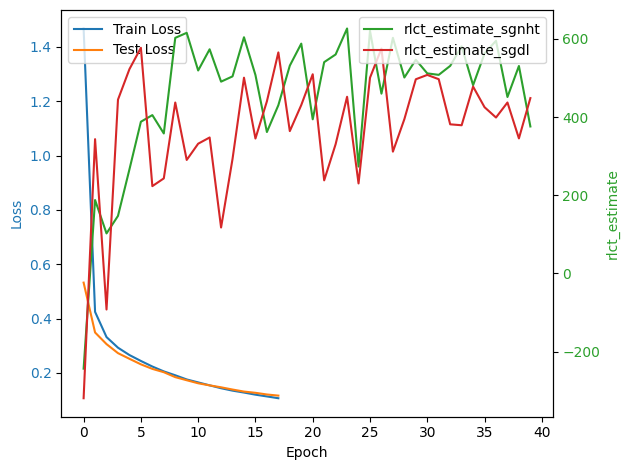

In [ ]:
import numpy as np
np.save('rlct_estimates_sgdl.npy', rlct_estimates_sgdl)
np.save('rlct_estimates_sgnht.npy', rlct_estimates_sgnht)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.plot(test_losses, label='Test Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.set_ylabel('rlct_estimate', color='tab:green')
ax2.plot(rlct_estimates_sgnht, label='rlct_estimate_sgnht', color='tab:green')
ax2.plot(rlct_estimates_sgdl, label='rlct_estimate_sgdl', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()